Installing ipython-autotime to keep everything timed.

In [ ]:
!pip install ipython-autotime

%load_ext autotime

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 2.25 s (started: 2021-03-31 01:58:25 +00:00)


Loading and normalizing CIFAR10,
We are using torchvision to load CIFAR-10.
The output of torchvision datasets are PILImage images of range [0, 1]. We transform them to Tensors of normalized range [-1, 1].

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

#Samples to be loaded for each batch
batch = 20

# number of subprocesses to use for data loading
number_subprocess = 0

# percentage of training set to use as validation
validation_set_size = 0.20

transform = transforms.Compose([transforms.ToTensor(),transforms.
                                Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
#Training data set
trainset = torchvision.datasets.CIFAR10('data', train=True, 
                                        download=True, transform=transform)
#Test data set
testset = torchvision.datasets.CIFAR10('data', train=False, download=True, 
                                       transform=transform)

#indexes to be used for validation set
num_training = len(trainset)
indices = list(range(num_training))
np.random.shuffle(indices)
split = int(np.floor(validation_set_size * num_training))
train_index, valid_index = indices[split:], indices[:split]

# Obtaining training and validation batches
training_sampler = SubsetRandomSampler(train_index)
validation_sampler = SubsetRandomSampler(valid_index)

#train_loader
trainloader = torch.utils.data.DataLoader
(trainset, batch_size=batch, 
                      sampler=training_sampler, num_workers=number_subprocess)
#validation Loader
validation_loader = torch.utils.data.DataLoader
(trainset, batch_size=batch, sampler=validation_sampler, 
 num_workers=number_subprocess)
#Test Loader

testloader = torch.utils.data.DataLoader(
    testset, batch_size=batch, 
                              shuffle=False, num_workers=number_subprocess)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 
           'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified
time: 1.6 s (started: 2021-03-31 02:25:17 +00:00)


Showing Training Image as an example

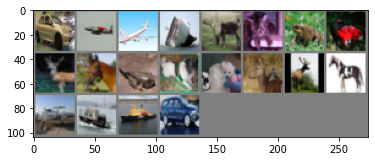

  car plane plane  ship  deer   cat  frog   car  deer horse  frog   dog   dog  deer  deer horse
time: 196 ms (started: 2021-03-31 02:25:19 +00:00)


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(16)))

Define a Convolutional Neural Network

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            #layer1
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 16 x 16
            #layer2
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 8 x 8
            nn.Dropout2d(p=0.05),
            #layer3
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 256 x 4 x 4

            nn.Flatten(), 
            nn.Linear(256*4*4, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(p=0.1),
            nn.Linear(512, 10))
        
    def forward(self, xb):
        return self.network(xb)

net = Net()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)
net.to(device)

cuda:0


Net(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Dropout2d(p=0.05, inplace=False)
    (11): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU()
    (13): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU()
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (16): Flatten(start_dim=1, end_dim=-1)
    (17): Linear(in_features=4096, out_features=1024, bias=True)
    (18): 

time: 78.8 ms (started: 2021-03-31 03:10:22 +00:00)


Define a loss funtion and optimizer

In [ ]:
import torch.optim as optim
#Loss_function
criterion = nn.CrossEntropyLoss()
#Optimizer
optimizer = optim.SGD(net.parameters(), lr=0.01)


time: 2.1 ms (started: 2021-03-31 03:10:30 +00:00)


Train the network

In [ ]:
#To store minimum value of validation loss
Minimun_validation_loss = np.Inf
nepochs = [*range(32)]
training_losslist = []
for epoch in nepochs:  # loop over the dataset multiple times

    running_loss = 0.0
    training_loss = 0.0
    
    net.train()
    for data, target in (trainloader):
        if device:
            data, target = data.cuda(), target.cuda()

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(data)
        loss = criterion(outputs, target)
        loss.backward()
        optimizer.step()

        training_loss += loss.item()*data.size(0)
    net.eval()
    for data, target in validation_loader:
        if device:
            data, target = data.cuda(), target.cuda()
        outputs = net(data)
        # calculate the batch loss
        loss = criterion(outputs, target)
        # update average validation loss 
        running_loss += loss.item()*data.size(0)
    
    # calculate average losses
    training_loss = training_loss/len(trainloader.dataset)
    running_loss = running_loss/len(validation_loader.dataset)

    training_losslist.append(training_loss)
        
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, training_loss, running_loss))
    
    PATH = './cifar_net.pth'
    torch.save(net.state_dict(), PATH)
    if running_loss <= Minimun_validation_loss:
        print('This is the new minimum validation loss ({:.6f} --> {:.6f}).  '
        .format(
        Minimun_validation_loss,running_loss))
        torch.save(net.state_dict(), PATH)
        Minimun_validation_loss = running_loss
print('Finished Training')

Epoch: 0 	Training Loss: 1.842244 	Validation Loss: 0.460525
This is the new minimum validation loss (inf --> 0.460525).  
Epoch: 1 	Training Loss: 1.842097 	Validation Loss: 0.460478
This is the new minimum validation loss (0.460525 --> 0.460478).  
Epoch: 2 	Training Loss: 1.841784 	Validation Loss: 0.460320
This is the new minimum validation loss (0.460478 --> 0.460320).  
Epoch: 3 	Training Loss: 1.826035 	Validation Loss: 0.419361
This is the new minimum validation loss (0.460320 --> 0.419361).  
Epoch: 4 	Training Loss: 1.547222 	Validation Loss: 0.347358
This is the new minimum validation loss (0.419361 --> 0.347358).  
Epoch: 5 	Training Loss: 1.325703 	Validation Loss: 0.319636
This is the new minimum validation loss (0.347358 --> 0.319636).  
Epoch: 6 	Training Loss: 1.215171 	Validation Loss: 0.290791
This is the new minimum validation loss (0.319636 --> 0.290791).  
Epoch: 7 	Training Loss: 1.128532 	Validation Loss: 0.272887
This is the new minimum validation loss (0.29079

Loading back in the saved model

In [ ]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

time: 70.6 ms (started: 2021-03-31 03:21:44 +00:00)


Testing the network on the test data

In [ ]:
# track test loss


total_class = list(0. for i in range(10))
testing_loss = 0.0
correct_class = list(0. for i in range(10))
net.eval()
if device:
            data, target = data.cuda(), target.cuda()
# iterating over testing data
for data, target in testloader:
    
    outputs = net(data)
   
    # calculating the batch wise loss
    los = criterion(outputs, target)
    # updating testing loss 
    testing_loss += los.item()*data.size(0)
    
    _, pred = torch.max(outputs, 1)    
    
    correct_ten = pred.eq(target.data.view_as(pred))
    cor = np.squeeze(correct_tensor.numpy()) if not device else 
    np.squeeze(correct_ten.cpu().numpy())
    
    for i in range(batch):
        label = target.data[i]
        correct_class[label] += cor[i].item()
        total_class[label] += 1

# average test loss
testing_loss = testing_loss/len(testloader.dataset)
print('Testing Loss: {:.6f}\n'.format(testing_loss))

for i in range(10):
  if total_class[i] > 0:
    print('Testing Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * correct_class[i] / total_class[i],
            np.sum(correct_class[i]), np.sum(total_class[i])))
  else:
    print('Testing Accuracy of ' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(correct_class) / np.sum(total_class),
    np.sum(correct_class), np.sum(total_class)))


Testing Loss: 1.571604

Testing Accuracy of plane: 79% (791/1000)
Testing Accuracy of   car: 89% (892/1000)
Testing Accuracy of  bird: 64% (645/1000)
Testing Accuracy of   cat: 53% (538/1000)
Testing Accuracy of  deer: 69% (690/1000)
Testing Accuracy of   dog: 60% (608/1000)
Testing Accuracy of  frog: 84% (848/1000)
Testing Accuracy of horse: 80% (801/1000)
Testing Accuracy of  ship: 83% (833/1000)
Testing Accuracy of truck: 86% (862/1000)

Test Accuracy (Overall): 75% (7508/10000)
time: 47 s (started: 2021-03-31 03:21:52 +00:00)


Lets Plot the output to make it user friendly and viewable

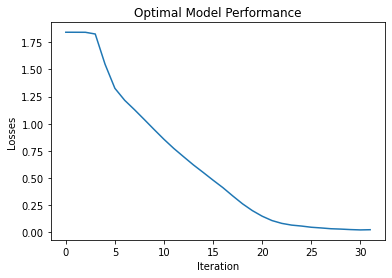

time: 130 ms (started: 2021-03-31 03:43:56 +00:00)


In [ ]:
plt.plot(nepochs, training_losslist)
plt.xlabel("Iteration")
plt.ylabel("Losses")
plt.title("Optimal Model Performance")
plt.show()